# EDA

In [2]:
# helper.py
from helper import *

# gpu acceleration
# import cudf as pd

# Import Data

In [3]:
# read in the data
root = 'data/'
data = pd.read_parquet(root + 'train_series.parquet')
events = pd.read_csv(root + 'train_events.csv')
test = pd.read_parquet(root + 'test_series.parquet')

# view head
data.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


- <ins>series_id</ins>: unique id for each user
- <ins>step</ins>: time step (0 is moment that user began using device) 
- <ins>timestamp</ins>: time of event
- <ins>anglez</ins>: "z-angle". Angle of arm relative to the vertical axis of the body
- <ins>enmo</ins>: quantifies physical activity. Very low values (close to 0) indicate sleep or rest

In [5]:
# print unique series_id
print(f'{data["series_id"].nunique()} unique series_id')

# show the shape and nulls
show_shape_and_nulls(data)

277 unique series_id
Shape: (127946340, 5)
Null values:


,series_id,step,timestamp,anglez,enmo
0,0,0,0,0,0


- __127m__ rows (no nulls) where each row represents a user at a 5-second interval.
- 277 unique users in the data.

In [4]:
# view head
events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


__Events__ are the labels, where we have the onset and wakeup events for every night for each user.

In [5]:
# print unique series_id
print(f'{events['series_id'].nunique()} unique series_id')

# show the shape and nulls
show_shape_and_nulls(events)

277 unique series_id
Shape: (14508, 5)
Null values:


,series_id,night,event,step,timestamp
0,0,0,0,4923,4923


- __14.5k rows__ (7254 total days). Half are onset times, half are wakeup times.
- Null values in the step and timestamp cols indicate that no sleep was detected (device wasn't worn).

# Timestamp

In [6]:
# look at unique timezone offsets
events['timestamp'].str[-5:].unique()

array(['-0400', '-0500'], dtype=object)

In [ ]:
# list of dfs
dfs = [data, events, test]

# iterate over each df
for df in dfs:
    # extract the timezone offset (last 5 characters)
    df['tz_offset'] = df['timestamp'].str.slice(start=-5)

    # remove the timezone offset
    df['timestamp_clean'] = df['timestamp'].str.slice(stop=-5)

    # convert the cleaned timestamp to datetime "YYYY-MM-DDTHH:MM:SS"
    df['timestamp_clean'] = pd.to_datetime(df['timestamp_clean'], format="%Y-%m-%dT%H:%M:%S")

    # create date and time columns
    df['date'] = df['timestamp_clean'].dt.date
    df['time'] = df['timestamp_clean'].dt.time

# check range of dates
events.query('date.notnull()')['date'].min(), events.query('date.notnull()')['date'].max()

TypeError: '<=' not supported between instances of 'datetime.date' and 'float'

In [16]:
# query events where date is not null
events.query('date.notnull()')['date'].min(), events.query('date.notnull()')['date'].max()

(datetime.date(2017, 8, 5), datetime.date(2019, 7, 5))

- Dates range from August 5th, 2017 - July 5th, 2019.

In [21]:
events

,series_id,night,event,step,timestamp,tz_offset,timestamp_clean,date,time,missing_sleep,missing_event
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400,-0400,2018-08-14 22:26:00,2018-08-14,22:26:00,False,False
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400,-0400,2018-08-15 06:41:00,2018-08-15,06:41:00,False,False
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400,-0400,2018-08-15 19:37:00,2018-08-15,19:37:00,False,False
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400,-0400,2018-08-16 05:41:00,2018-08-16,05:41:00,False,False
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400,-0400,2018-08-16 23:03:00,2018-08-16,23:03:00,False,False
...,...,...,...,...,...,...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400,-0400,2017-09-06 04:07:00,2017-09-06,04:07:00,False,False
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400,-0400,2017-09-06 23:35:00,2017-09-06,23:35:00,False,False
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400,-0400,2017-09-07 09:17:00,2017-09-07,09:17:00,False,False
14506,fe90110788d2,35,onset,NaN,NaN,NaN,NaT,NaT,NaT,True,True


,count,mean,std,min,25%,50%,75%,max
tot_recorded_nights,277.0,15.509025,8.907583,0.0,9.0,16.0,22.0,35.0


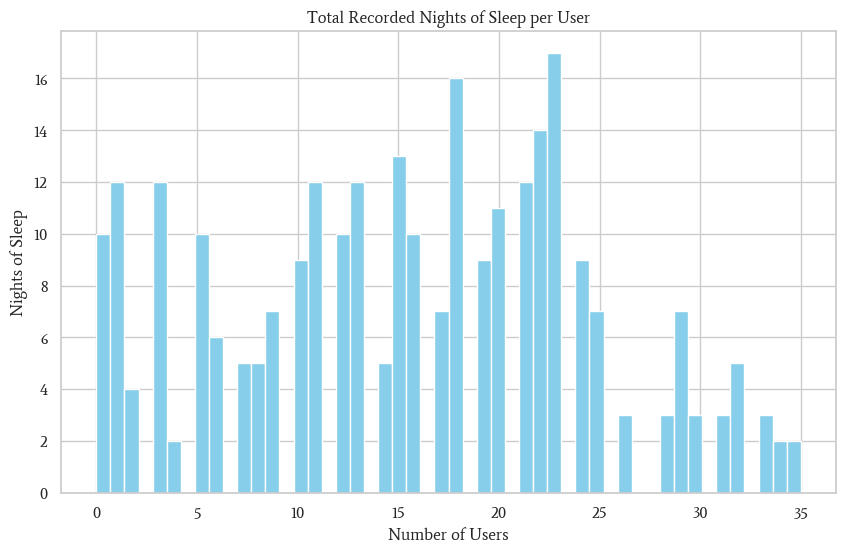

In [111]:
# create the missing_sleep column: True if step is missing, else False
events['missing_event'] = events['step'].isna()

# group by series_id and aggregate in one pass
aggregated = events.groupby('series_id').agg(
    tot_events=('event', 'count'),
    tot_nights=('night', 'last'),
    tot_missing_events=('missing_event', 'sum')
).reset_index()

# divide total_missing_sleep by 2 (using integer division) to get tot_missing_nights.
aggregated['tot_missing_nights'] = (aggregated['tot_missing_events'] // 2).astype(int)

# add tot_recorded_events and tot_recorded_nights columns
aggregated['tot_recorded_events'] = aggregated['tot_events'] - aggregated['tot_missing_events']
aggregated['tot_recorded_nights'] = aggregated['tot_nights'] - aggregated['tot_missing_nights']

# plot nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_recorded_nights'].hist(bins=50, ax=ax, color='skyblue')
ax.set_title('Total Recorded Nights of Sleep per User')
ax.set_ylabel('Nights of Sleep')
ax.set_xlabel('Number of Users');

# descibe
aggregated[['tot_recorded_nights']].describe().T

- Each user had about 15-16 nights of recorded sleep.

,count,mean,std,min,25%,50%,75%,max
tot_missing_nights,277.0,8.877256,10.443399,0.0,2.0,5.0,13.0,72.0


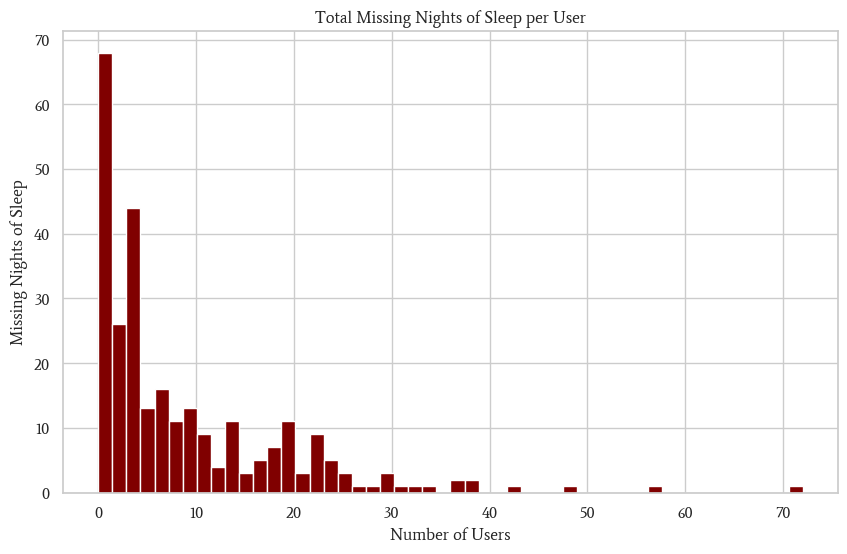

In [112]:
# plot missing nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
aggregated['tot_missing_nights'].hist(bins=50, ax=ax, color='maroon')
ax.set_title('Total Missing Nights of Sleep per User')
ax.set_ylabel('Missing Nights of Sleep')
ax.set_xlabel('Number of Users');

# descibe
aggregated[['tot_missing_nights']].describe().T

- Users usually failed to record about 5 nights of sleep.
- One user failed to wear the device for 72 nights.

# Visualize

In [117]:
aggregated.query('tot_nights < 5')

,series_id,tot_events,tot_nights,tot_missing_events,tot_missing_nights,tot_recorded_events,tot_recorded_nights
4,05e1944c3818,16,1,2,1,14,0
18,10469f6765bf,8,2,2,1,6,1
25,13b4d6a01d27,10,1,2,1,8,0
36,1c7c0bad1263,14,4,2,1,12,3
43,27f09a6a858f,44,2,2,1,42,1
59,349c5562ee2c,4,2,0,0,4,2
129,7df249527c63,44,2,2,1,42,1
191,bdfce9ce62b9,44,3,2,1,42,2
229,d93b0c7de16b,46,1,2,1,44,0
267,f6d2cc003183,44,1,2,1,42,0


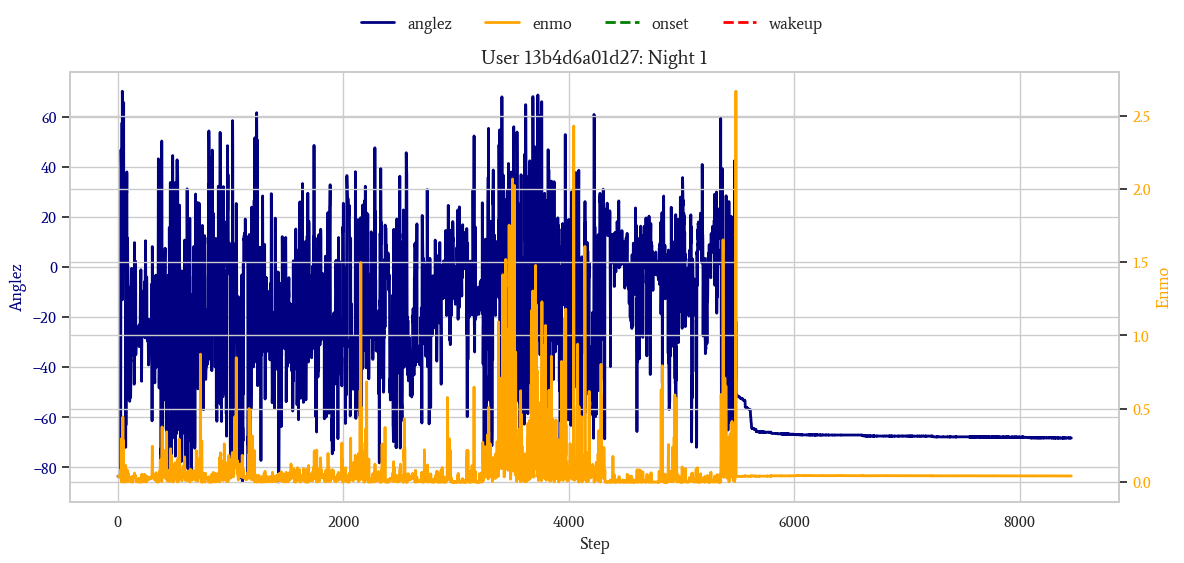

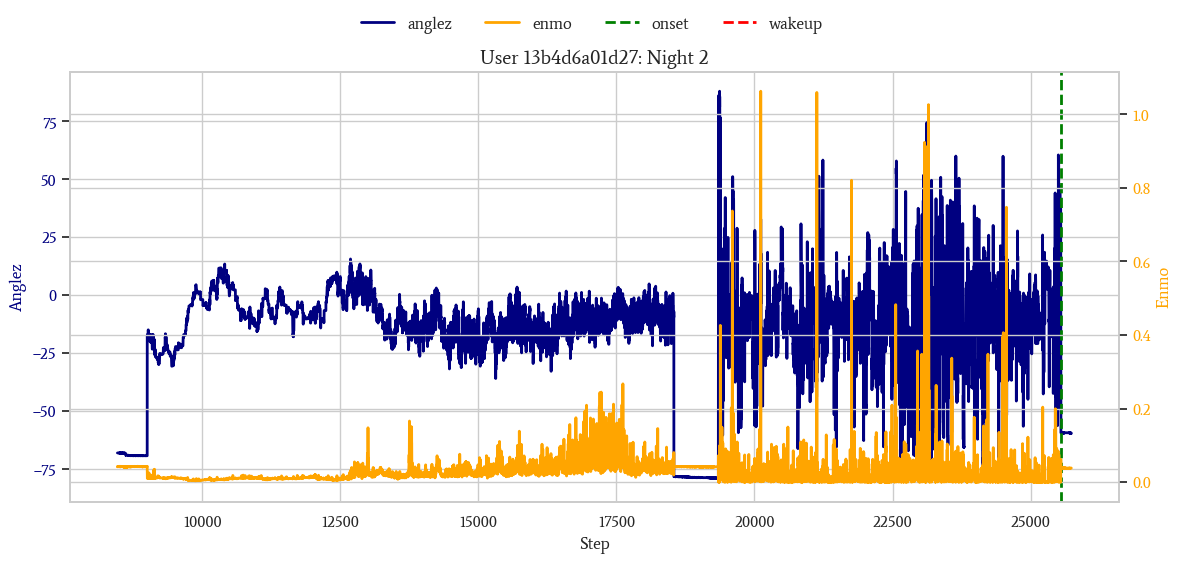

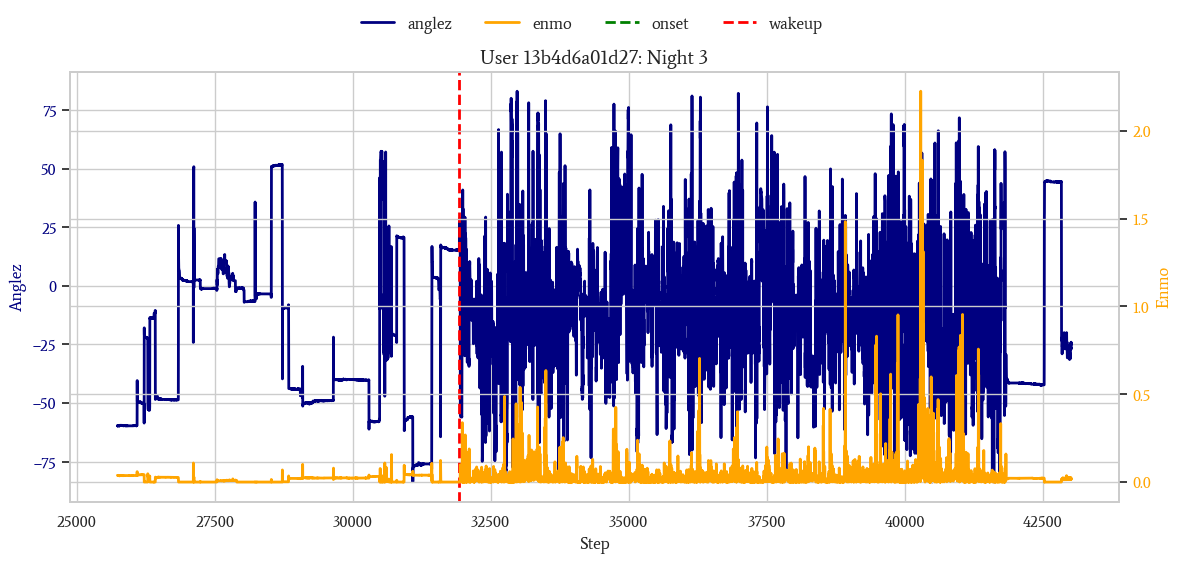

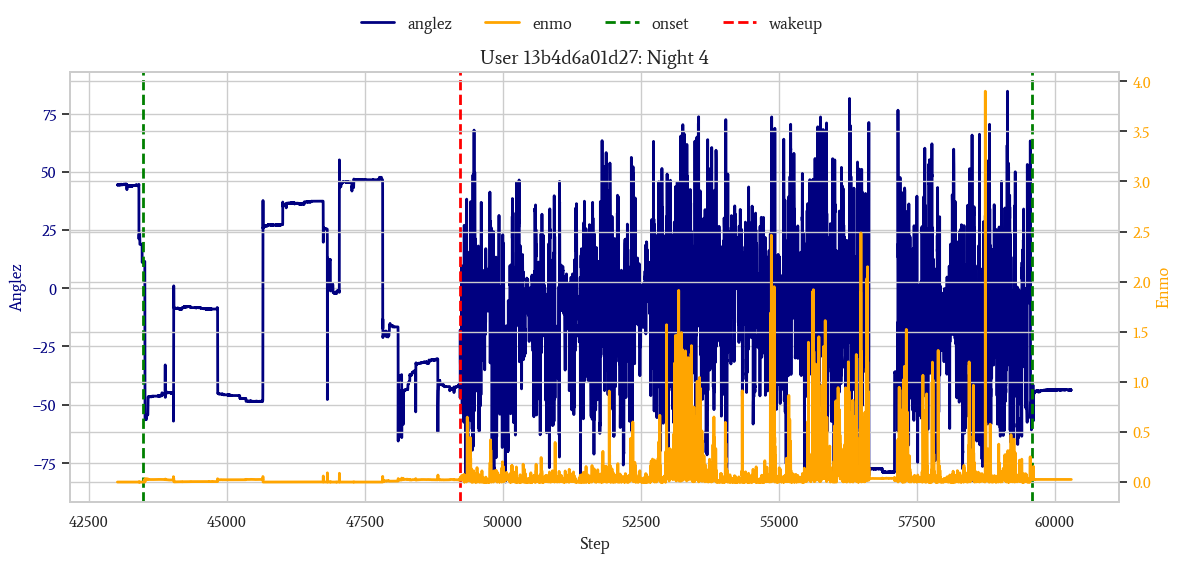

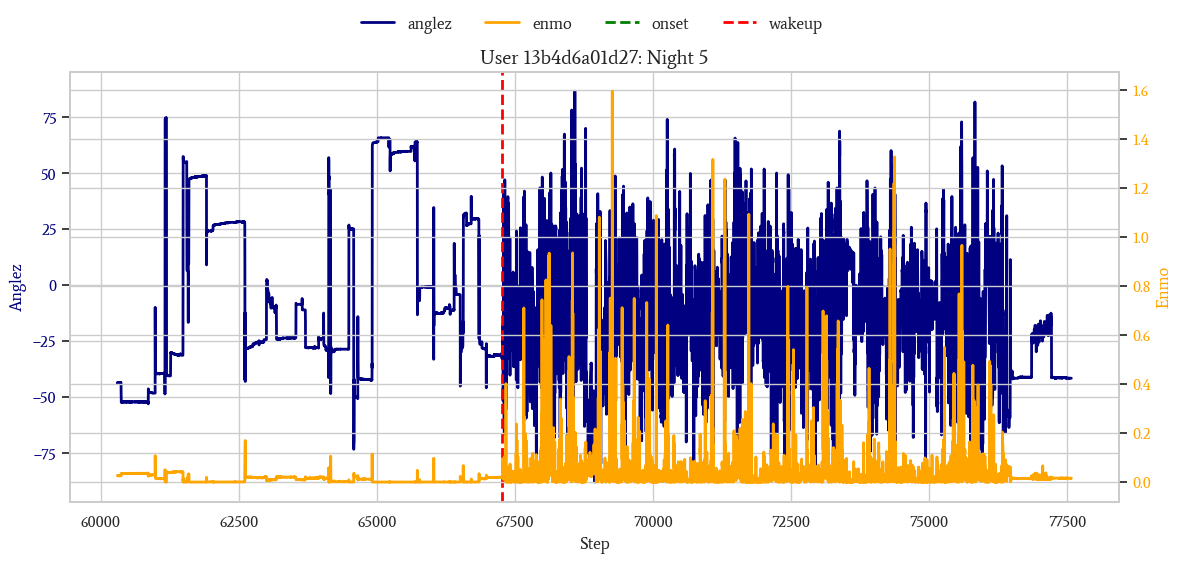

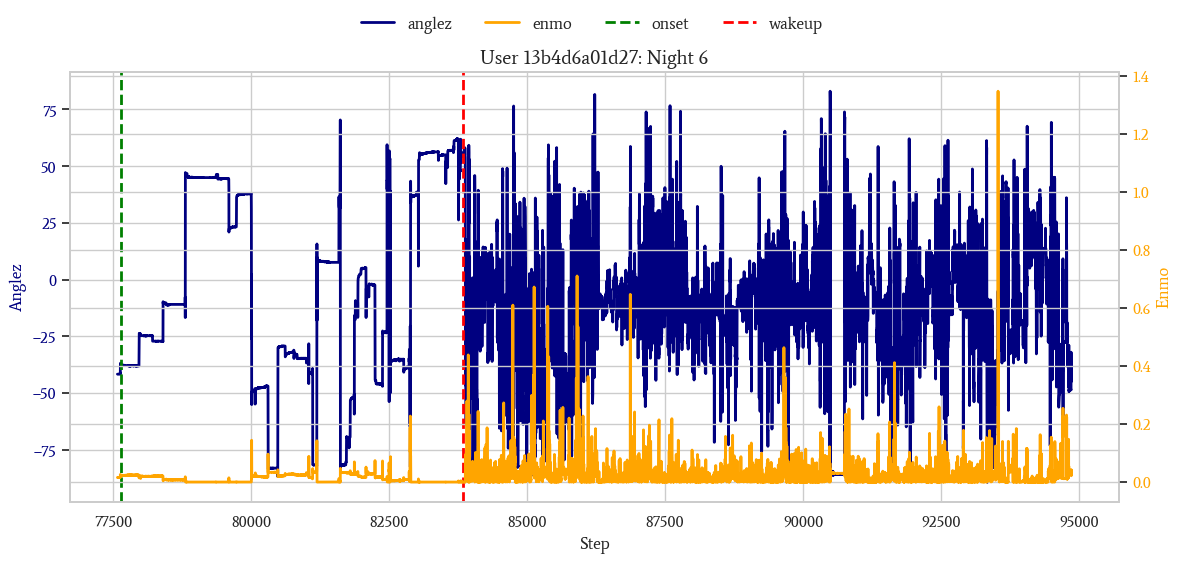

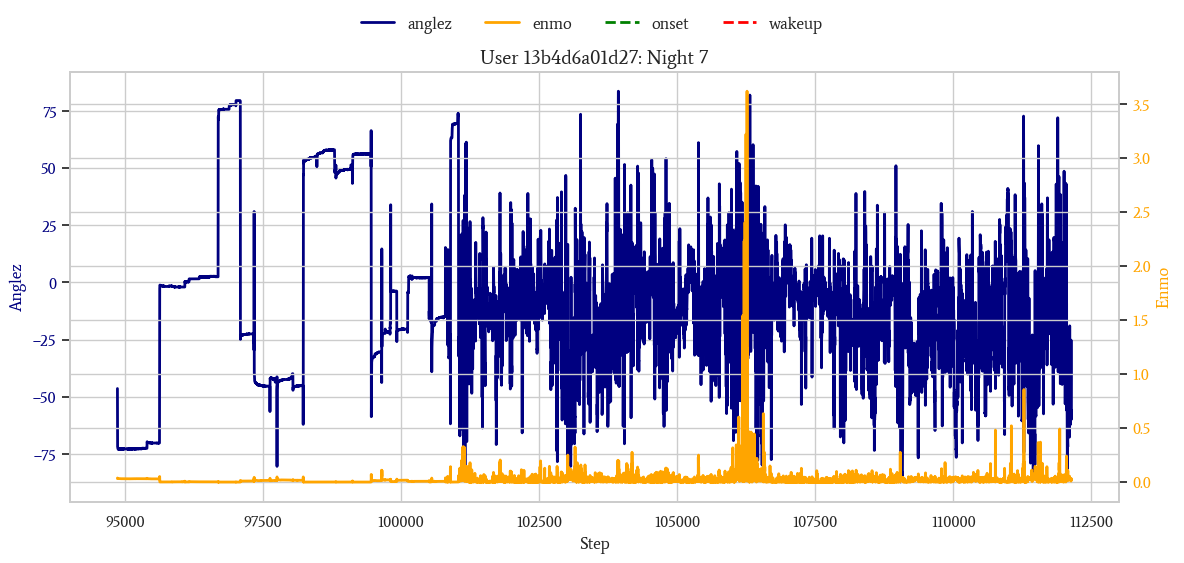

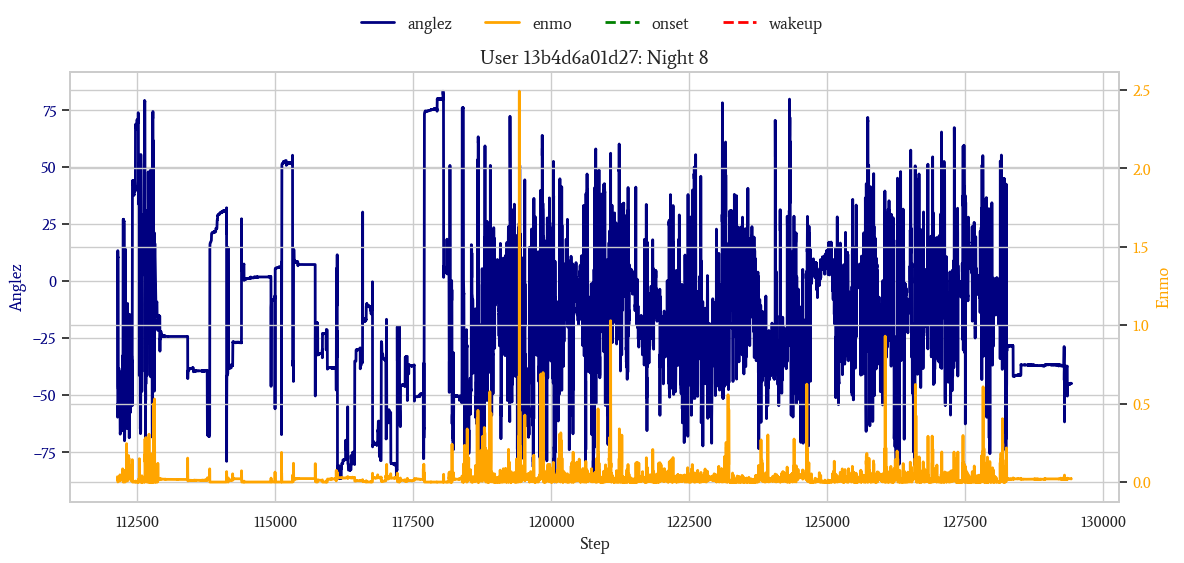

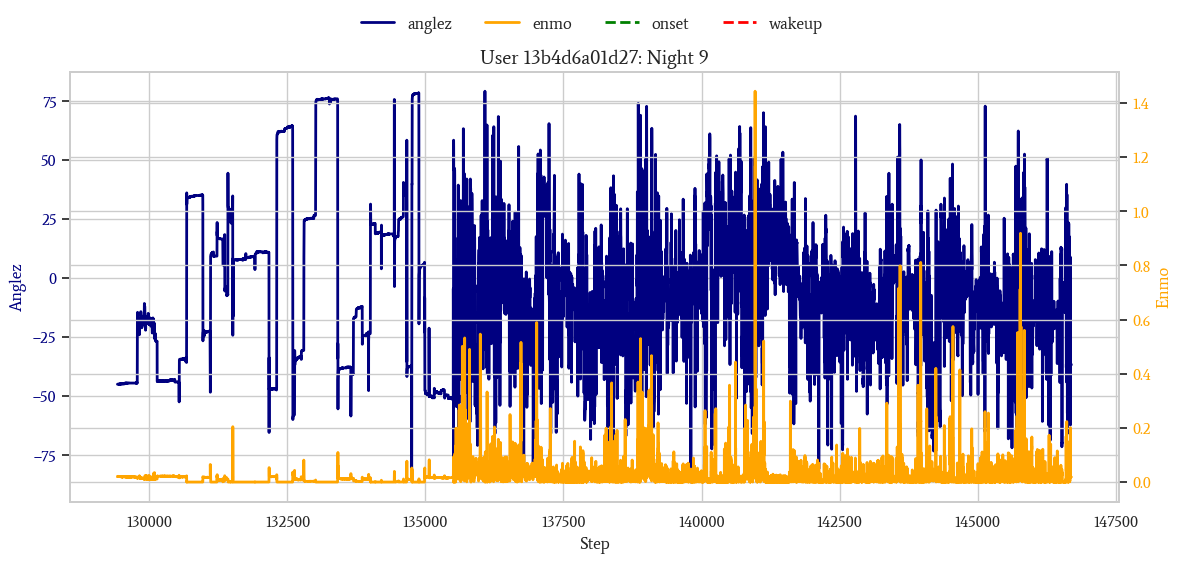

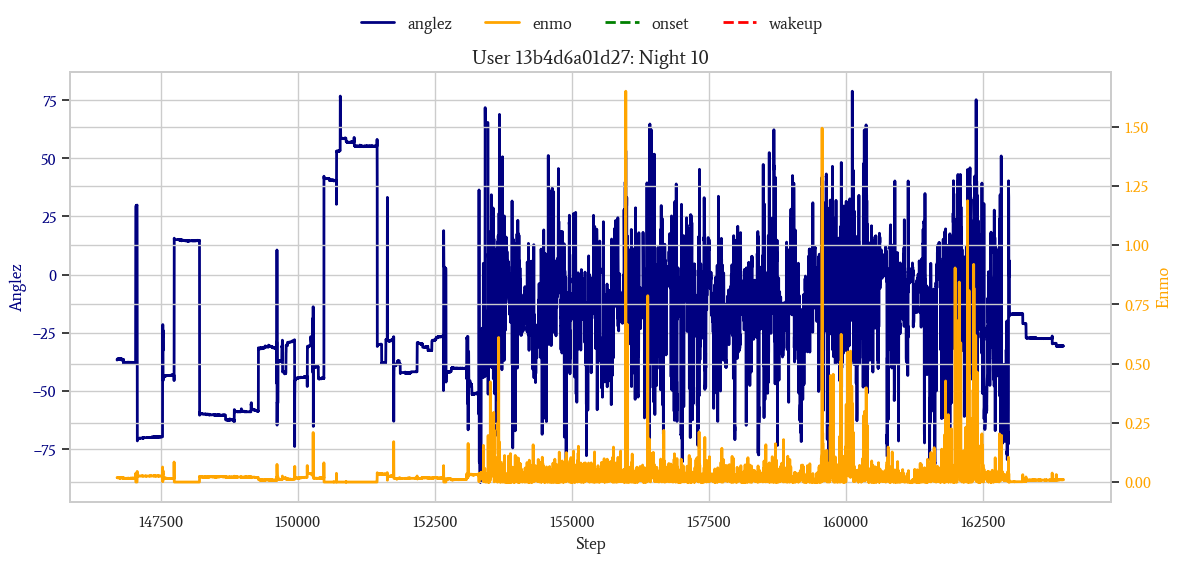

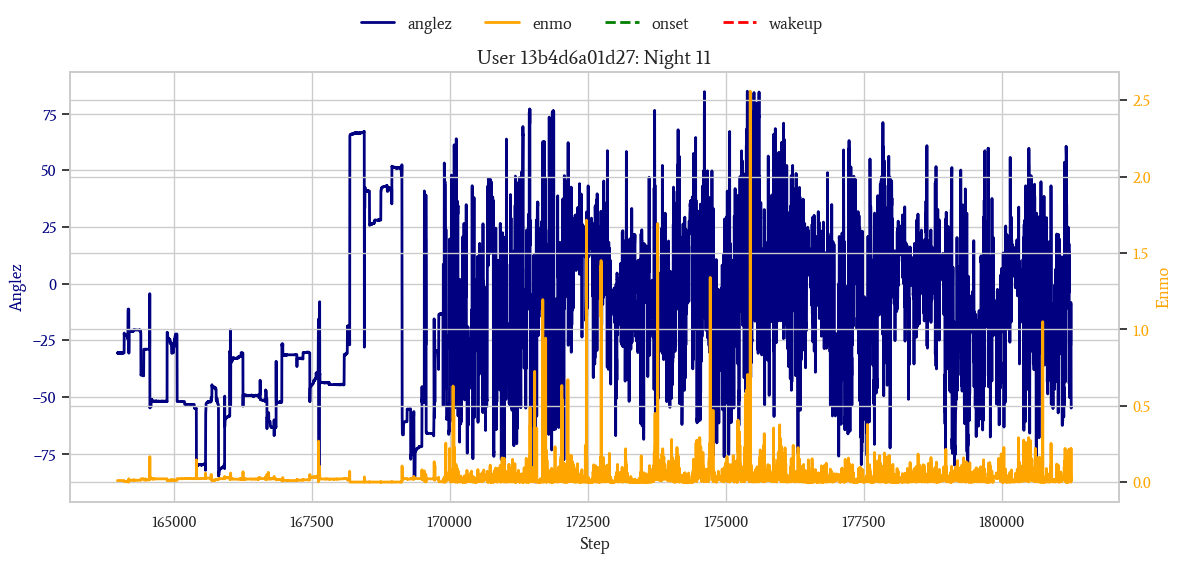

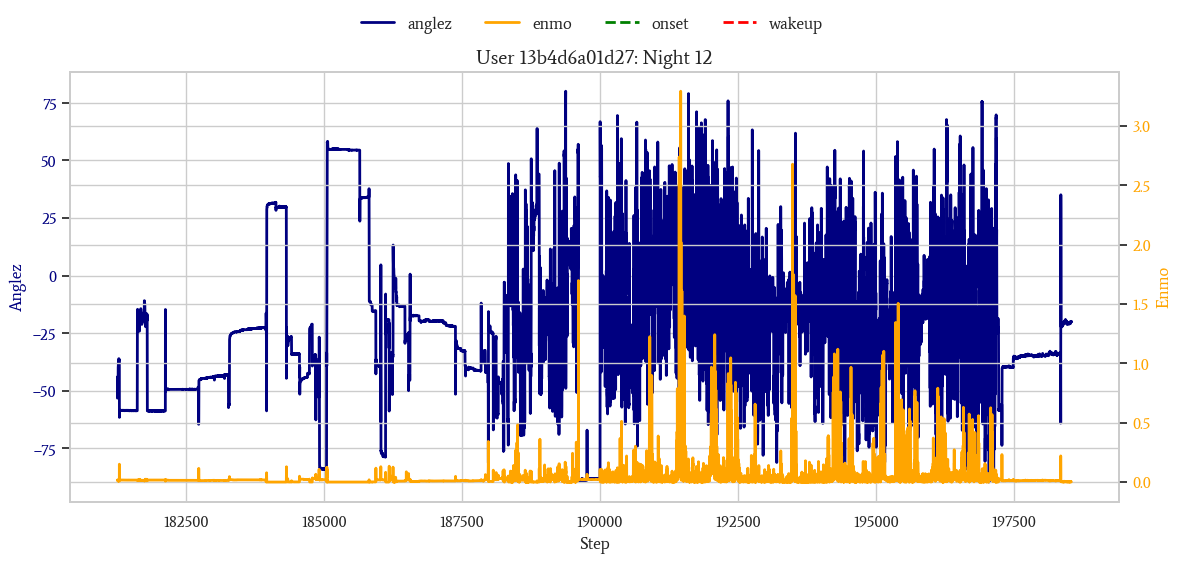

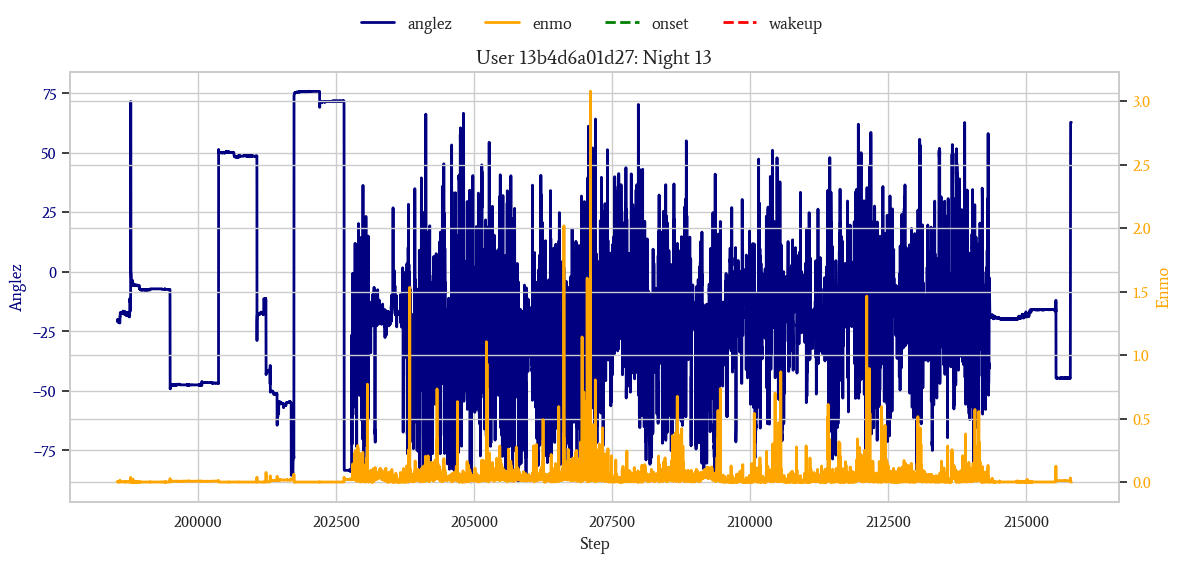

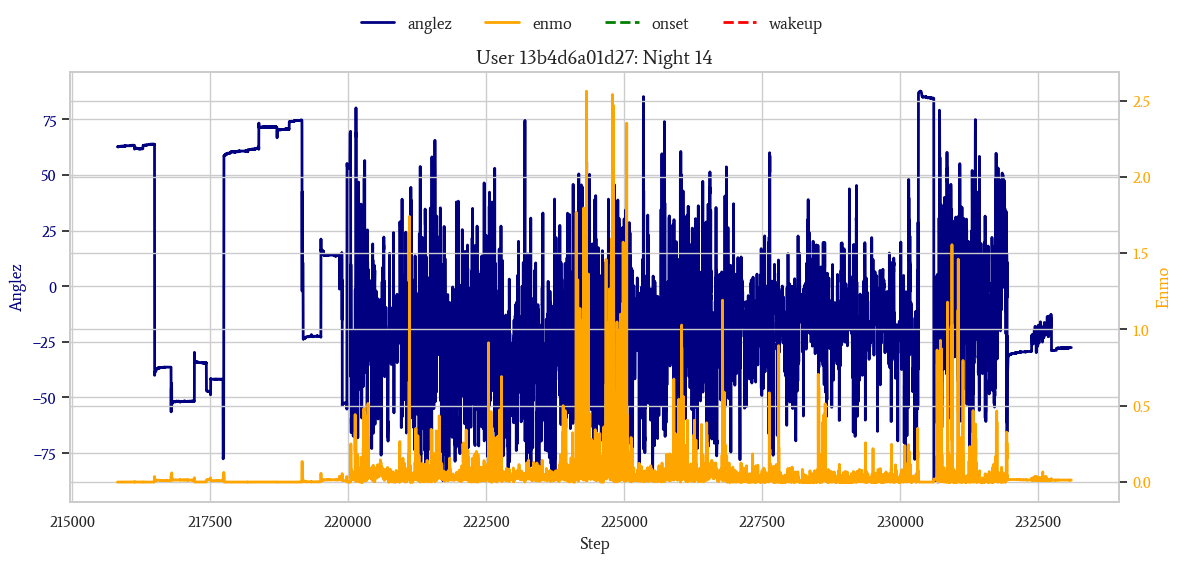

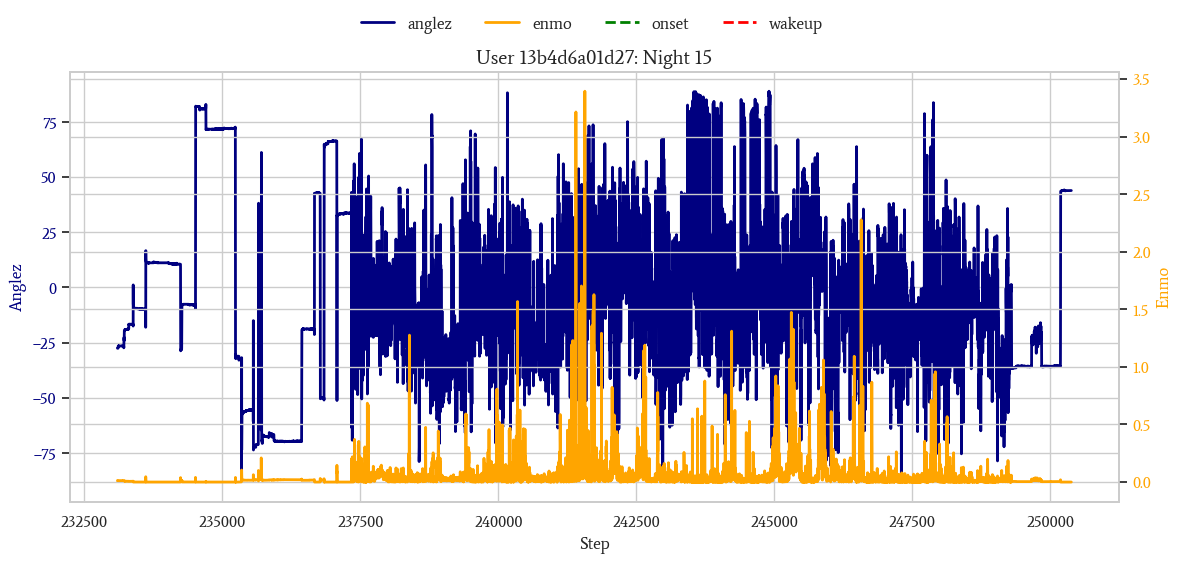

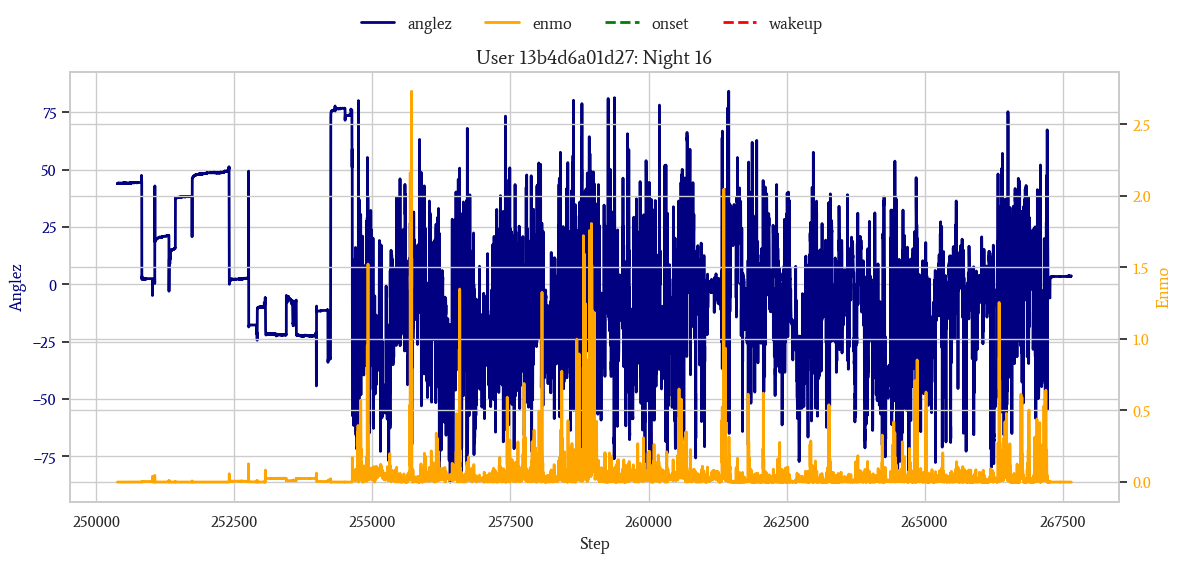

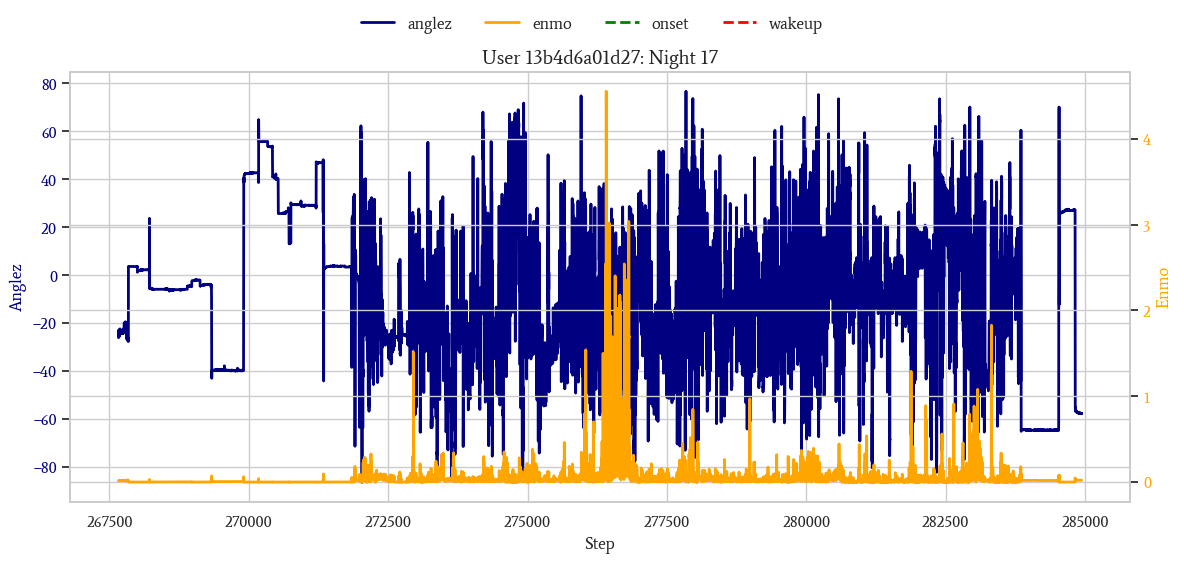

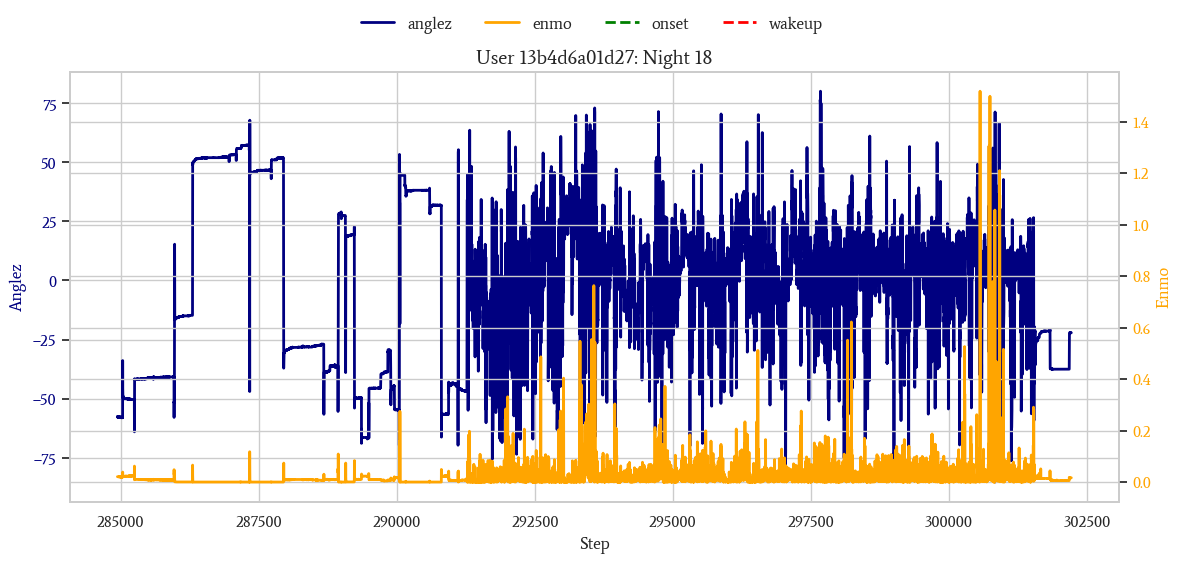

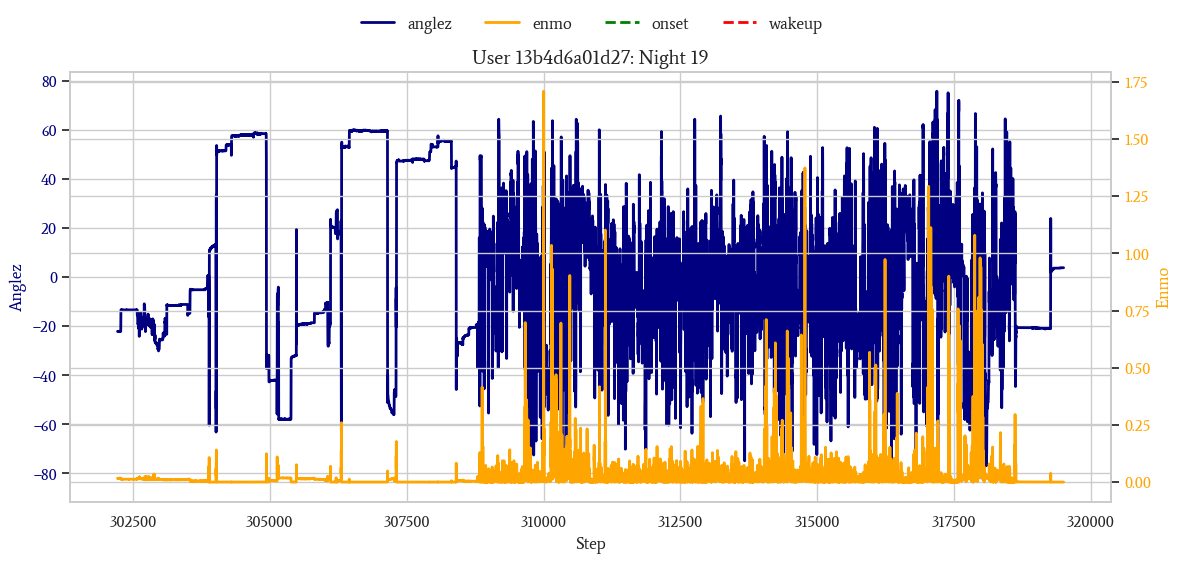

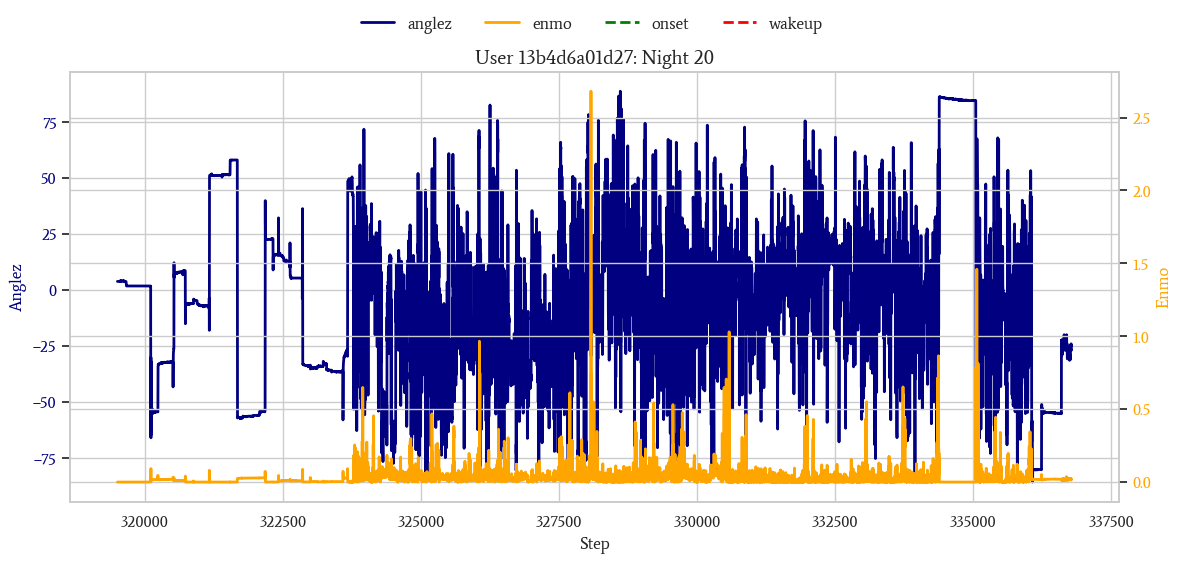

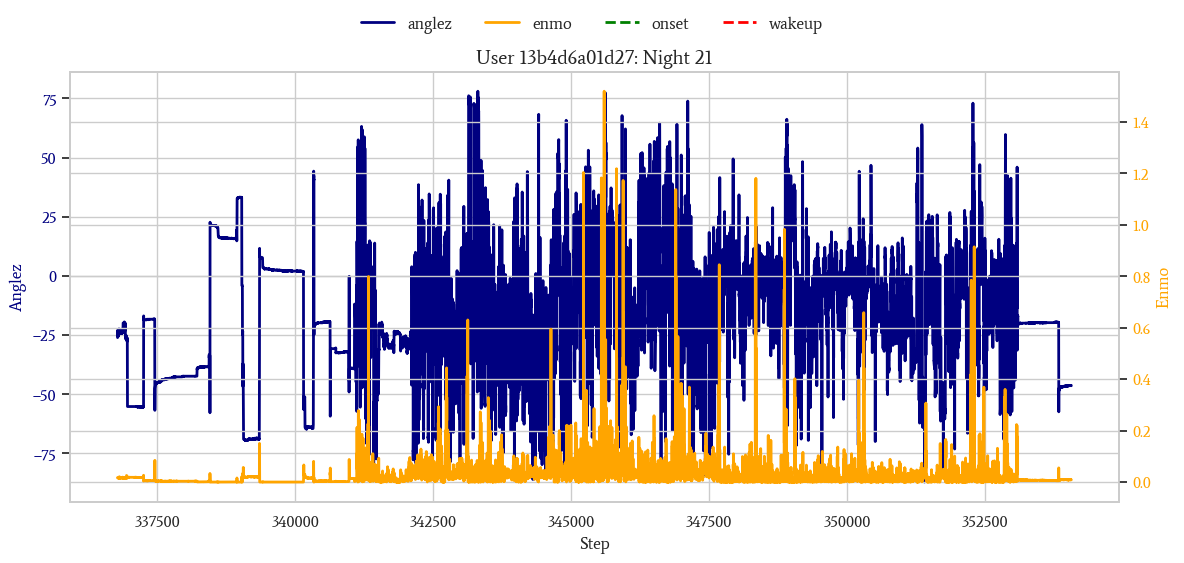

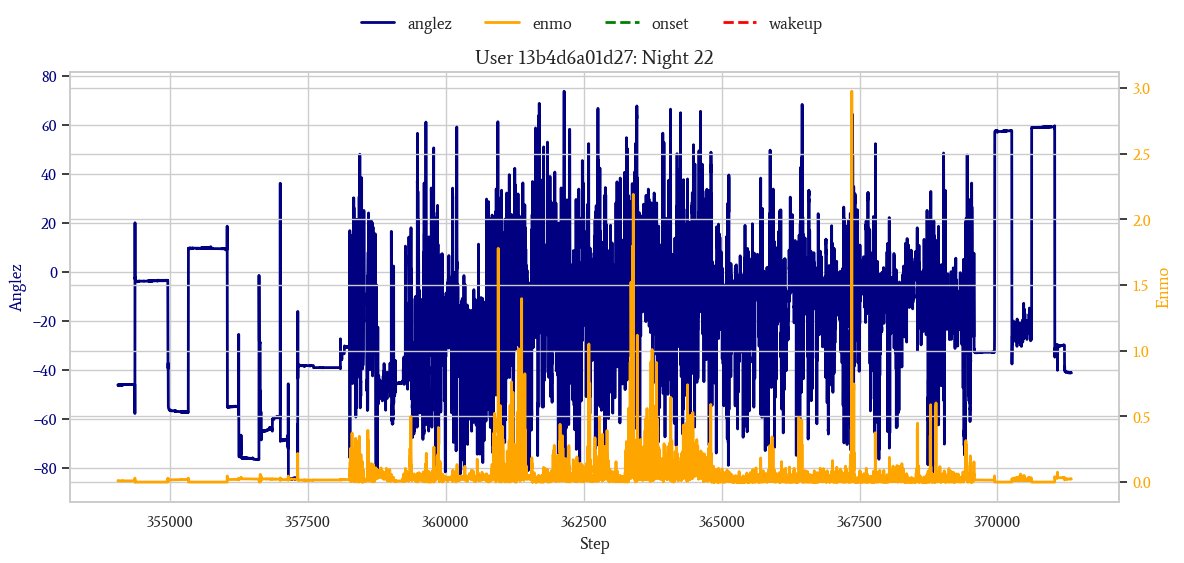

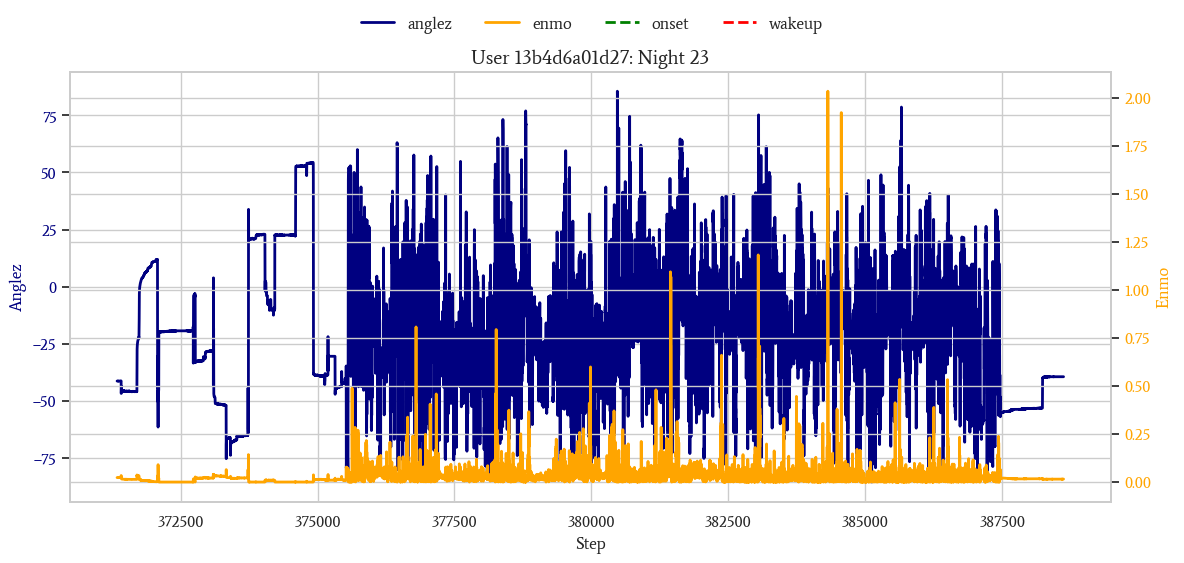

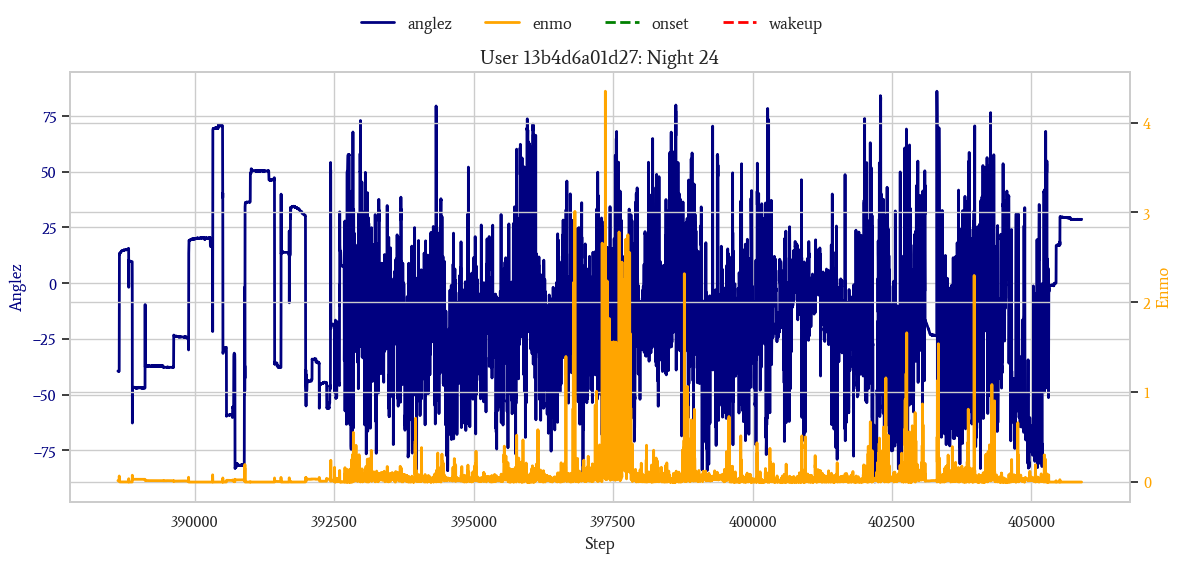

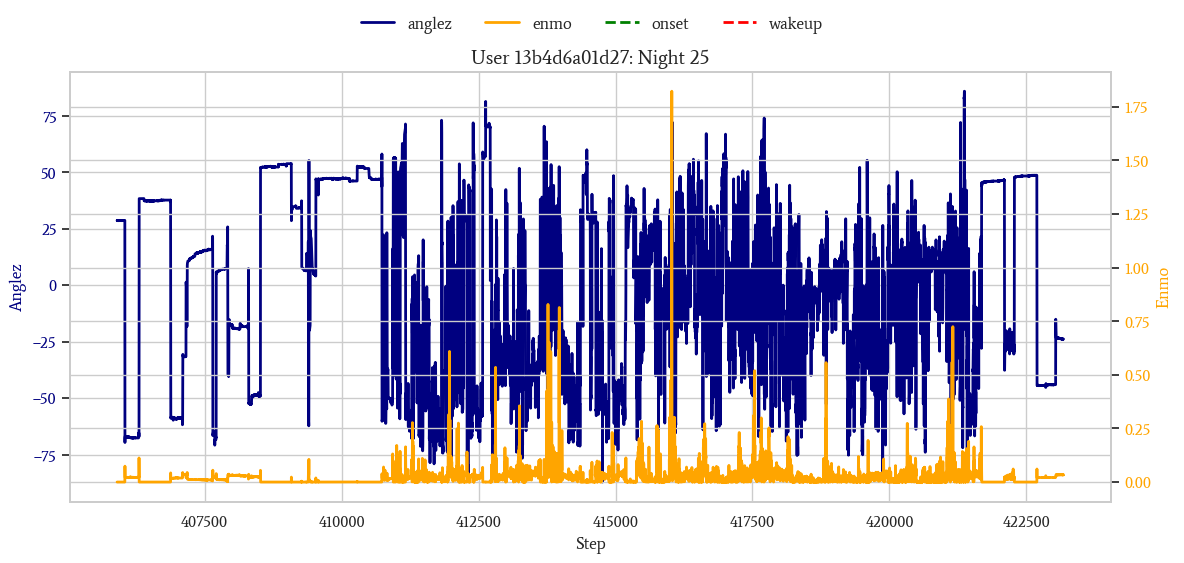

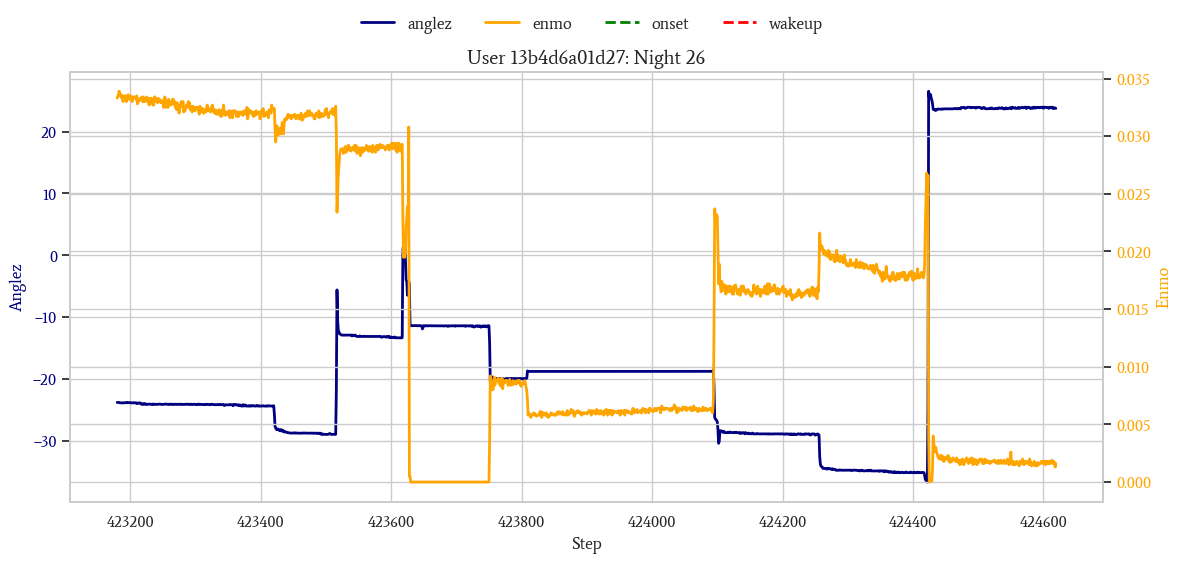

In [120]:
# get a random series_id with under 5 total nights of sleep
id = get_random_id(df=aggregated.query('tot_nights < 5'))

# get their data
user_rows = data.query('series_id == @id')

# plot sleep cycles for a user
plot_sleep_cycles(user_rows, events)

- While the user is asleep, we see that anglez has a staircase-like shape. Enmo is generally low during these times.
- During periods where the user is awake, we see that anglez has a high variance, and constant motion. Enmo (a measure of activity) is generally higher during these periods of wakefullness.
- Periods of inactivity are easy to spot as well. During these periods, anglez stagnates around 0 and has a lower variance. Enmo also stagnates, and is usually at its highest.

In [121]:
# save data
data.to_parquet(root + 'train_series_clean.parquet', index=False)
events.to_csv(root + 'train_events_clean.csv', index=False)
test.to_parquet(root + 'test_series_clean.parquet', index=False)